In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [43]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
!curl $data > CreditScoring.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178k  100  178k    0     0   882k      0 --:--:-- --:--:-- --:--:--  882k


In [46]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [47]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [48]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [49]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [50]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

My code:

What are the categorical variables? What are the numerical?

In [66]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

numerical_columns   = list(df.dtypes[df.dtypes == 'int64'].index)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [53]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

Q1

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score and compute AUC with the "default" variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front
(e.g. -df_train['expenses'])
AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive


Which numerical variable (among the following 4) has the highest AUC?

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [64]:
a = roc_auc_score(y_train, -df_train.seniority)
b = roc_auc_score(y_train, df_train.time)
c = roc_auc_score(y_train, -df_train.income)
d = roc_auc_score(y_train, -df_train.debt)

a,b,c,d

(0.7093778624491943, 0.5608662489595051, 0.682006666132633, 0.5047829675783548)


From now on, use these columns only:
['seniority', 'income', 'assets', 'records', 'job', 'home']
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [69]:
cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = df_train[cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [71]:
val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [73]:
roc_auc_score(y_val, y_pred)

0.8120879813449298

Q3

In [79]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['recall']    = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

df_scores[::10]

,threshold,tp,fp,fn,tn,recall,precision
0,0.0,246,645,0,0,1.000000,0.276094
10,0.1,235,445,11,200,0.955285,0.345588
20,0.2,215,267,31,378,0.873984,0.446058
30,0.3,187,162,59,483,0.760163,0.535817
40,0.4,140,100,106,545,0.569106,0.583333
50,0.5,114,64,132,581,0.463415,0.640449
60,0.6,78,38,168,607,0.317073,0.672414
70,0.7,37,16,209,629,0.150407,0.698113
80,0.8,21,5,225,640,0.085366,0.807692
90,0.9,6,2,240,643,0.024390,0.750000


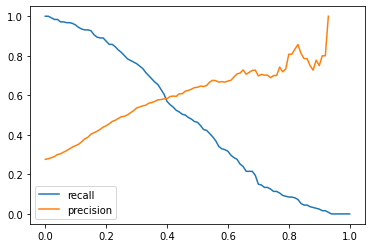

In [81]:
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.legend()

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

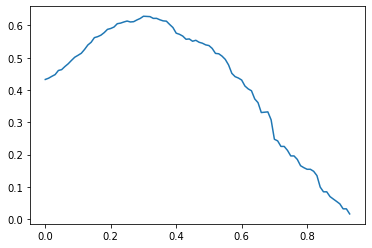

In [85]:
f1 = 2*(df_scores.precision*df_scores.recall)/(df_scores.precision+df_scores.recall)
plt.plot(df_scores.threshold, f1)

Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation

In [96]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

from sklearn.model_selection import KFold

In [97]:
!pip install tqdm

In [98]:
from tqdm.auto import tqdm


In [100]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015

